# Grafo del ejemplo
Creamos el grafo del ejemplo de clase

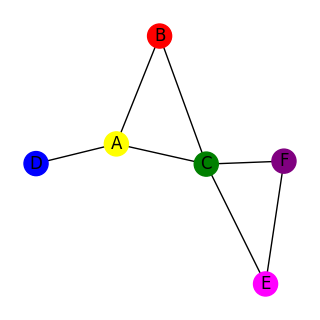

In [1]:
import matplotlib.pyplot as plt
import networkx as nx

G = nx.from_edgelist([
    (0, 1), 
    (0, 2), 
    (0, 3), 
    (1, 2), 
    (2, 4), 
    (2, 5), 
    (4, 5)
])

nx.set_node_attributes(G, {n: [float(n),float(n)] for n in G.nodes()}, 'x')
nx.set_node_attributes(G, {n: float(G.degree(n)) for n in G.nodes()}, 'y')

plt.figure(figsize=(3, 3))
colors = {
    0: "yellow",
    1: "red",
    2: "green",
    3: "blue",
    4: "magenta",
    5: "purple"
}
nx.draw(G, with_labels=True, node_color=[colors[i] for i in range(6)], labels={0:'A', 1:'B', 2:'C', 3:'D', 4:'E', 5:'F'})

# Implementacion manual
Implementamos el paso de mensajes usando las ecuaciones vistas en clase

$M^l = B^l + Z^{l-1}W^l$

$Z^l = D^{-\frac{1}{2}} A D^{-\frac{1}{2}}$

$Z^0 = X$

In [2]:
import torch

# Graph input
A = torch.tensor(nx.adjacency_matrix(G).todense(),dtype=torch.float32)
D = torch.diag(torch.sum(A, dim=1)**-0.5)
A = D @ A @ D
X = torch.tensor([G.nodes[i]['x'] for i in G.nodes()], dtype=torch.float32)
Y = torch.tensor([G.nodes[i]['y'] for i in G.nodes()], dtype=torch.float32).reshape(-1, 1)

# Model definition
nfeatures = 2
nclasses = 1

W_1 = torch.randn(nfeatures, 32, requires_grad=True)
B_1 = torch.randn(32, requires_grad=True)

W_2 = torch.randn(32, 32, requires_grad=True)
B_2 = torch.randn(32, requires_grad=True)

CLS = torch.randn(32, nclasses, requires_grad=True)
B_CLS = torch.randn(nclasses, requires_grad=True)

# Message passing
def forward():
    ML = B_1 + X @ W_1
    H = torch.relu(A @ ML)
    
    ML = B_2 + H @ W_2
    H = torch.relu(A @ ML)

    H = torch.relu(H @ CLS + B_CLS)
    return H

# Loss
loss = torch.nn.MSELoss()

# Optimization
optimizer = torch.optim.Adam([W_1, B_1, W_2, B_2, CLS, B_CLS], lr=0.001)
for i in range(10000):
    optimizer.zero_grad()
    Y_pred = forward()
    l = loss(Y_pred, Y)
    l.backward()
    optimizer.step()
    if i % 1000 == 0:
        print(l.item())

y_pred = forward().detach().numpy()
print(f"Predicted: {[format(i, '.2f') for i in y_pred.flatten()]}")
print(f"Actual: {[format(i, '.2f') for i in Y.flatten().numpy()]}")

612.827392578125
0.38435813784599304
0.0847417414188385
0.0658038929104805
0.05634307861328125
0.05140600726008415
0.04480773210525513
0.03583778813481331
0.02512233518064022
0.014622196555137634
Predicted: ['3.00', '1.87', '3.98', '1.15', '2.06', '2.01']
Actual: ['3.00', '2.00', '4.00', '1.00', '2.00', '2.00']


# Implementacion con Pytorch Geometric

Implementamos el mismo ejemplo usando pytroch geometric

## Cargar Grafo a pythorch geometric

In [2]:
from torch_geometric.utils.convert import from_networkx

data = from_networkx(G)
print(data)

print(f"Attributes: {data.keys()}")
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Number of node features: {data.num_node_features}")
print(f"Number of edge features: {data.num_edge_features}")
print(f"Contains isolated nodes: {data.has_isolated_nodes()}")
print(f"Contains self-loops: {data.has_self_loops()}")
print(f"Is undirected: {data.is_undirected()}")

Data(x=[6, 2], edge_index=[2, 14], y=[6])
Attributes: ['y', 'x', 'edge_index']
Number of nodes: 6
Number of edges: 14
Number of node features: 2
Number of edge features: 0
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


## Definir Red

Implementación de GCN de [pytorch_geometric]()

$ \mathbf{z}_i^{l} = W^l \sum_{j \in \mathcal{N}(i) \cup \{i\}} \frac{\mathbf{x}_j^{l-1}}{\sqrt{d_j d_i}} + b^l$

In [65]:
import torch
from torch_geometric.nn import GCNConv, MLP
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self, node_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.cls = MLP(in_channels=hidden_channels, out_channels=num_classes, num_layers=1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.cls(x)
        return x

## Optimizar

In [67]:
model = GCN(node_features=data.num_node_features, hidden_channels=32, num_classes=1)

# Loss
loss = torch.nn.MSELoss()

# Optimization
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

for i in range(300):
    optimizer.zero_grad()
    Y_pred = model(data.x, data.edge_index)
    l = loss(Y_pred, data.y.reshape(-1, 1))
    l.backward()
    optimizer.step()
    if i % 10 == 0:
        print(l.item())

y_pred = model(data.x, data.edge_index).detach().numpy()
print(f"Predicted: {[format(i, '.2f') for i in y_pred.flatten()]}")
print(f"Actual: {[format(i, '.2f') for i in data.y.flatten().numpy()]}")

7.596360683441162
1.2639518976211548
0.8472058773040771
0.7289588451385498
0.7016707062721252
0.6856345534324646
0.6505118012428284
0.5882881283760071
0.5034441947937012
0.4440000057220459
0.41278085112571716
0.36798763275146484
0.31914129853248596
0.28400784730911255
0.2499871402978897
0.21222759783267975
0.19176210463047028
0.16453123092651367
0.13799874484539032
0.10919567197561264
0.08032403141260147
0.04847432300448418
0.022421857342123985
0.024399861693382263
0.010339937172830105
0.0031603306997567415
0.0021455860696733
0.0011079993564635515
0.0007424320210702717
0.00045849065645597875
Predicted: ['2.97', '2.03', '4.00', '1.02', '2.00', '2.00']
Actual: ['3.00', '2.00', '4.00', '1.00', '2.00', '2.00']


# Caso real: Citations

Probaremos la red en un dataset real con una tarea real, prediccion de la categoria de un paper segun la red de citas.

* Los nodos son articulos
* Las aristas son citas entre articulos
* Los atributos de los nodos representan el texto del articulo.
* Predecir una categoria de entre 7 posibles

## Cargar dataset

In [16]:
from torch_geometric.datasets import CitationFull

dataset = CitationFull(root='CitationFull', name='Cora_ML')
print(f"Number of graphs: {len(dataset)}")

data = dataset[0]
print(f"Attributes: {data.keys()}")
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Number of node features: {data.num_node_features}")
print(f"Number of edge features: {data.num_edge_features}")
print(f"Number of classes: {dataset.num_classes}")
print(f"Contains isolated nodes: {data.has_isolated_nodes()}")
print(f"Contains self-loops: {data.has_self_loops()}")
print(f"Is undirected: {data.is_undirected()}")

Processing...


Number of graphs: 1
Attributes: ['y', 'x', 'edge_index']
Number of nodes: 2995
Number of edges: 16316
Number of node features: 2879
Number of edge features: 0
Number of classes: 7
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


Done!


## Definir una capa nueva de paso de mensajes

$ \mathbf{z}_i^{l} = W^l \sum_{j \in \mathcal{N}(i) \cup \{i\}} \mathbf{x}_j^{l-1} $

* **MSG**: $m_u^l = b^l + W^lz^{l-1}_u $
* **AGG**: $a_u^l = \sum_{v \in N(u) \cup \{u\}} m_v^l$ 
* **UPDATE**: $z_u^l = a_u^l$

In [27]:
import torch
from torch.nn import Linear, Parameter
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops

class CustomGCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(CustomGCNConv, self).__init__(aggr='sum')
        
        self.W_m = Linear(in_channels, out_channels)
        self.b_m = Parameter(torch.Tensor(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        self.W_m.reset_parameters()
        self.b_m.data.zero_()

    def forward(self, x, edge_index):
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        return self.propagate(edge_index, x=x)
    
    def message(self, x_j):
        return self.W_m(x_j) + self.b_m
    
    def update(self, aggr_out):
        return aggr_out

## Definir una red

In [28]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import  MLP

class GCN(torch.nn.Module):
    def __init__(self, node_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = CustomGCNConv(node_features, hidden_channels)
        self.conv2 = CustomGCNConv(hidden_channels, hidden_channels)
        self.cls = MLP(in_channels=hidden_channels, out_channels=num_classes, num_layers=2, hidden_channels=hidden_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.cls(x)
        return x

## Dividir dataset

In [29]:
import numpy as np
from sklearn.model_selection import train_test_split

train_idx, test_idx = train_test_split(np.arange(data.num_nodes), test_size=0.2, stratify=data.y)

train_mask = np.zeros(data.num_nodes, dtype=bool)
train_mask[train_idx] = True

test_mask = np.zeros(data.num_nodes, dtype=bool)
test_mask[test_idx] = True

data.train_mask = torch.tensor(train_mask)
data.test_mask = torch.tensor(test_mask)

## Train

In [32]:
from torch.nn import CrossEntropyLoss
from torchmetrics.classification import MulticlassF1Score
from torch.optim import Adam

model = GCN(dataset.num_node_features, 16, dataset.num_classes)

optimizer = Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
optm_func = CrossEntropyLoss()
metric = MulticlassF1Score(num_classes=dataset.num_classes)

model.train()
for epoch in range(300):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = optm_func(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss {loss.item()}")

Epoch 0: Loss 1.9902137517929077
Epoch 10: Loss 1.6970956325531006
Epoch 20: Loss 1.4844785928726196
Epoch 30: Loss 1.2917561531066895
Epoch 40: Loss 1.1757278442382812
Epoch 50: Loss 1.0376250743865967
Epoch 60: Loss 0.9295595288276672
Epoch 70: Loss 0.9273625612258911
Epoch 80: Loss 0.8349145650863647
Epoch 90: Loss 0.8305865526199341
Epoch 100: Loss 0.8356637954711914
Epoch 110: Loss 0.7314668297767639
Epoch 120: Loss 0.664432942867279
Epoch 130: Loss 0.767339289188385
Epoch 140: Loss 0.640615701675415
Epoch 150: Loss 0.6425914168357849
Epoch 160: Loss 0.5915405750274658
Epoch 170: Loss 0.5684178471565247
Epoch 180: Loss 0.5905574560165405
Epoch 190: Loss 0.5661591291427612
Epoch 200: Loss 0.58221435546875
Epoch 210: Loss 0.633258581161499
Epoch 220: Loss 0.594312846660614
Epoch 230: Loss 0.5572912096977234
Epoch 240: Loss 0.6170610189437866
Epoch 250: Loss 0.5644599795341492
Epoch 260: Loss 0.5924892425537109
Epoch 270: Loss 0.6029545068740845
Epoch 280: Loss 0.5391306281089783
Epo

## Test model

F1 score: 0.7479131886477463


<Axes: >

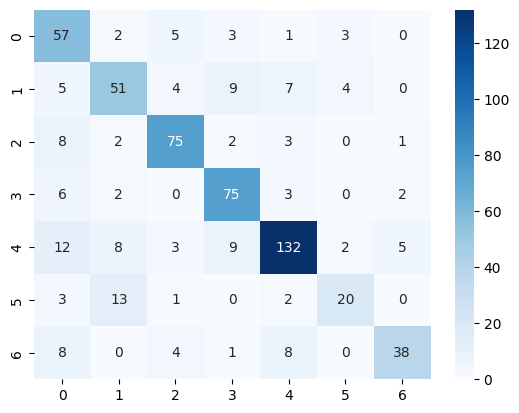

In [33]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score

model.eval()
y_pred = out.argmax(dim=1)[data.test_mask].detach().cpu()
y = data.y[data.test_mask].detach().cpu()

print(f"F1 score: {f1_score(y, y_pred, average='micro')}")
sns.heatmap(confusion_matrix(y, y_pred), annot=True, fmt='g', cmap='Blues')

# Agregador universal
$\text{MLP}_{\theta} \left( \sum_{v \in N(u)} \text{MLP}_{\phi} \left( z_v^{l-1} \right) \right)$

* **MSG**: $m_u^l = \text{MLP}_{\phi} \left( z_v^{l-1} \right) $
* **AGG**: $a_u^l = \sum_{v \in N(u)} m_v^l$ 
* **UPDATE**: $z_u^l = \text{MLP}_{\theta} \left( a_v^{l} \right)$

## Definir la capa del agregador universal

In [ ]:
from torch_geometric.nn import MessagePassing, MLP

class UniversalAggregatorConv(MessagePassing):
    def __init__(self, in_channels, out_channels, hidden_channels, num_layers):
        super(UniversalAggregatorConv, self).__init__(aggr='sum')
        
        self.MLP_phi = MLP(
            in_channels=in_channels, 
            out_channels=out_channels,
            hidden_channels=hidden_channels, 
            num_layers=num_layers
        )
        self.MLP_theta = MLP(
            in_channels=out_channels, 
            out_channels=out_channels,
            hidden_channels=hidden_channels, 
            num_layers=num_layers
        )

        self.reset_parameters()

    def reset_parameters(self):
        self.MLP_phi.reset_parameters()
        self.MLP_theta.reset_parameters()

    def forward(self, x, edge_index):
        return self.propagate(edge_index, x=x)
    
    def message(self, x_j):
        return self.MLP_phi(x_j)
    
    def update(self, aggr_out):
        return self.MLP_theta(aggr_out)

## Definir la red

In [30]:
import torch
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self, node_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = UniversalAggregatorConv(node_features, hidden_channels, 32, 2)
        self.conv2 = UniversalAggregatorConv(hidden_channels, hidden_channels, 32, 2)
        self.cls = Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.cls(x)
        return x

## Cargar dataset

In [25]:
from torch_geometric.datasets import CitationFull

dataset = CitationFull(root='CitationFull', name='Cora_ML')
print(f"Number of graphs: {len(dataset)}")

data = dataset[0]
print(f"Attributes: {data.keys()}")
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Number of node features: {data.num_node_features}")
print(f"Number of edge features: {data.num_edge_features}")
print(f"Number of classes: {dataset.num_classes}")
print(f"Contains isolated nodes: {data.has_isolated_nodes()}")
print(f"Contains self-loops: {data.has_self_loops()}")
print(f"Is undirected: {data.is_undirected()}")

Number of graphs: 1
Attributes: ['y', 'x', 'edge_index']
Number of nodes: 2995
Number of edges: 16316
Number of node features: 2879
Number of edge features: 0
Number of classes: 7
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


## Dividir dataset

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

train_idx, test_idx = train_test_split(np.arange(data.num_nodes), test_size=0.2, stratify=data.y)

train_mask = np.zeros(data.num_nodes, dtype=bool)
train_mask[train_idx] = True

test_mask = np.zeros(data.num_nodes, dtype=bool)
test_mask[test_idx] = True

data.train_mask = torch.tensor(train_mask)
data.test_mask = torch.tensor(test_mask)

## Train

In [33]:
from torch.nn import CrossEntropyLoss
from torchmetrics.classification import MulticlassF1Score
from torch.optim import Adam

model = GCN(dataset.num_node_features, 16, dataset.num_classes)

optimizer = Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
optm_func = CrossEntropyLoss()
metric = MulticlassF1Score(num_classes=dataset.num_classes)

model.train()
for epoch in range(1000):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = optm_func(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss {loss.item()}")

Epoch 0: Loss 1.9344292879104614
Epoch 10: Loss 1.5932414531707764
Epoch 20: Loss 1.2875667810440063
Epoch 30: Loss 1.0677714347839355
Epoch 40: Loss 0.9261806607246399
Epoch 50: Loss 0.781301736831665
Epoch 60: Loss 0.7002854943275452
Epoch 70: Loss 0.6591644287109375
Epoch 80: Loss 0.5958453416824341
Epoch 90: Loss 0.5575027465820312
Epoch 100: Loss 0.5233505964279175
Epoch 110: Loss 0.5165451169013977
Epoch 120: Loss 0.49992525577545166
Epoch 130: Loss 0.522131085395813
Epoch 140: Loss 0.4998737573623657
Epoch 150: Loss 0.4156692922115326
Epoch 160: Loss 0.4522807002067566
Epoch 170: Loss 0.4287891983985901
Epoch 180: Loss 0.6342796683311462
Epoch 190: Loss 0.5512855052947998
Epoch 200: Loss 0.5063701868057251
Epoch 210: Loss 0.43262040615081787
Epoch 220: Loss 0.452006459236145
Epoch 230: Loss 0.4148917496204376
Epoch 240: Loss 0.40528640151023865
Epoch 250: Loss 0.4320220649242401
Epoch 260: Loss 0.3983735740184784
Epoch 270: Loss 0.4068012237548828
Epoch 280: Loss 0.4098232388496

## Test model

F1 score: 0.7946577629382304


<Axes: >

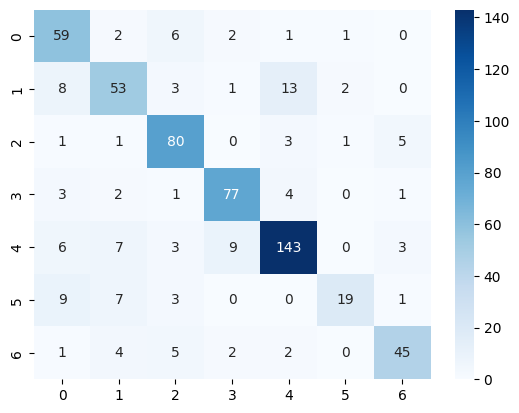

In [34]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score

model.eval()
y_pred = out.argmax(dim=1)[data.test_mask].detach().cpu()
y = data.y[data.test_mask].detach().cpu()

print(f"F1 score: {f1_score(y, y_pred, average='micro')}")
sns.heatmap(confusion_matrix(y, y_pred), annot=True, fmt='g', cmap='Blues')

# Janossy Pooling 

$MLP_\theta \left( \frac{1}{|\Pi|} \sum_{\pi \in \Pi} \mathbb{P}_\phi \left( z^{l-1}_1, \ldots, z^{l-1}_{|N(u)|} \right)_\pi \right)$

* **MSG**: $m_u^l = z_v^{l-1} $
* **AGG**: $a_u^l = \frac{1}{|\Pi|} \sum_{\pi \in \Pi} \mathbb{P}_\phi \left( z^{l-1}_1, \ldots, z^{l-1}_{|N(u)|} \right)_\pi $ 
* **UPDATE**: $z_u^l = \text{MLP}_{\theta} \left( a_v^{l} \right)$

## Capa con LSTM Aggregation + Janossy 

Implementaremos el método `aggregate` de la capa de paso de mensajes para hacer la agregación de janossy con la media de distintas permutaciones.

In [ ]:
import torch
from torch_geometric.nn import MessagePassing, LSTMAggregation, MLP

class JanossyConv(MessagePassing):
    def __init__(self, in_channels, out_channels, perm_steps=15):
        super(JanossyConv, self).__init__()
        self.aggr = LSTMAggregation(in_channels, out_channels)
        #self.aggr = SumAggregation()
        self.mlp_theta = MLP(
            in_channels=out_channels, 
            out_channels=out_channels,
            hidden_channels=out_channels, 
            num_layers=1
        )
        self.perm_steps = perm_steps

    def reset_parameters(self):
        self.aggr.reset_parameters()
        self.mlp_theta.reset_parameters()

    def forward(self, x, edge_index):
        return self.propagate(edge_index, x=x)

    def _do_aggegation_with_permutation(self, inputs, index):
        device = inputs.device

        range_index = torch.arange(inputs.shape[0], device=device)
        ei = torch.stack([range_index, index], axis=0)
        perm = torch.randperm(index.size(0), device=device)
        ei = ei[:, perm]
        order = torch.argsort(ei[1,:])
        ei = ei[:,order]
        
        agg = self.aggr(inputs[ei[0,:]], ei[1,:], max_num_elements=50)

        return agg
    
    def aggregate(self, inputs, index, ptr=None, dim_size=None):
        vector = self._do_aggegation_with_permutation(inputs, index) # genera un vector para cada una de las permutaciones
        for _ in range(self.perm_steps - 1): 
            vector = vector + self._do_aggegation_with_permutation(inputs, index) 

        return vector/float(self.perm_steps) # devuelve la media de las x vectores resultantes de la permutacion
        #return self.aggr(inputs, index)
    
    def update(self, aggr_out):
        return self.mlp_theta(aggr_out)

### Cómo funciona 
El método aggregaye recive los parámetros `index` e `inputs` que son los siguientes vectores

#### Cargar grafo de ejemplo

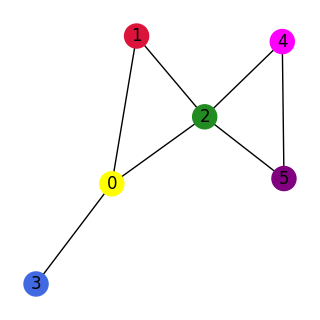

In [3]:
import matplotlib.pyplot as plt
import networkx as nx

G = nx.from_edgelist([
    (0, 1), 
    (0, 2), 
    (0, 3), 
    (1, 2), 
    (2, 4), 
    (2, 5), 
    (4, 5)
])

nx.set_node_attributes(G, {n: [float(n),float(n)] for n in G.nodes()}, 'x')
nx.set_node_attributes(G, {n: float(G.degree(n)) for n in G.nodes()}, 'y')

plt.figure(figsize=(3, 3))
colors = {
    0: "yellow",
    1: "crimson",
    2: "forestgreen",
    3: "royalblue",
    4: "magenta",
    5: "purple"
}
nx.draw(G, with_labels=True, node_color=[colors[i] for i in range(6)])

In [4]:
from torch_geometric.utils.convert import from_networkx

data = from_networkx(G)
data = data.sort(sort_by_row=False)
print(data)

print(f"Attributes: {data.keys()}")
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Number of node features: {data.num_node_features}")
print(f"Number of edge features: {data.num_edge_features}")
print(f"Contains isolated nodes: {data.has_isolated_nodes()}")
print(f"Contains self-loops: {data.has_self_loops()}")
print(f"Is undirected: {data.is_undirected()}")

Data(x=[6, 2], edge_index=[2, 14], y=[6])
Attributes: ['edge_index', 'x', 'y']
Number of nodes: 6
Number of edges: 14
Number of node features: 2
Number of edge features: 0
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


#### Clase Aggregator

![image.png](https://raw.githubusercontent.com/rusty1s/pytorch_scatter/master/docs/source/_figures/add.svg?sanitize=true)

Los aggregadores realizan la operación de agregación sobre los vecinos de un nodo. Hay varios implementados en pytorch geometric, ver la [documentación](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#aggregation-operators)  

In [ ]:
# implementacion manual 

import numpy as np

A = nx.adjacency_matrix(G).todense()
X = np.array([G.nodes[i]['x'] for i in G.nodes()])

A@X

array([[ 6.,  6.],
       [ 2.,  2.],
       [10., 10.],
       [ 0.,  0.],
       [ 7.,  7.],
       [ 6.,  6.]])

In [ ]:
# Agregador de pytroch geometric

from torch_geometric.nn import SumAggregation

x = data.x[data.edge_index[0,:]] # atributos de la primera fila de las aristas
index = data.edge_index[1,:]

print("Input:")
display(x)
print("Index:")
display(index)

print("Output:")
aggr = SumAggregation()
aggr(x, index)

#### Hacer permutaciones

In [70]:
# Aggregate receives two arguments: inputs and index

print("Edge index:")
display(data.edge_index)

index = data.edge_index[1,:]
inputs = data.x[data.edge_index[0,:]]

print("Inputs:")
display(inputs)

print("Index:")
display(index)

Edge index:


tensor([[1, 2, 3, 0, 2, 0, 1, 4, 5, 0, 2, 5, 2, 4],
        [0, 0, 0, 1, 1, 2, 2, 2, 2, 3, 4, 4, 5, 5]])

Inputs:


tensor([[1., 1.],
        [2., 2.],
        [3., 3.],
        [0., 0.],
        [2., 2.],
        [0., 0.],
        [1., 1.],
        [4., 4.],
        [5., 5.],
        [0., 0.],
        [2., 2.],
        [5., 5.],
        [2., 2.],
        [4., 4.]])

Index:


tensor([0, 0, 0, 1, 1, 2, 2, 2, 2, 3, 4, 4, 5, 5])

Hacer una permutación

In [80]:
# permutacion de aristas usando randperm
import torch

ei = data.edge_index[:, torch.randperm(data.edge_index.size(1))]
print("Permutation:")
display(ei)

x = data.x[ei[0],:]
index = ei[1,:]

print("Output:")
aggr = SumAggregation()
aggr(x, index)

Permutation:


tensor([[0, 2, 2, 4, 5, 2, 0, 1, 3, 5, 0, 4, 1, 2],
        [1, 5, 0, 2, 4, 1, 3, 0, 0, 2, 2, 5, 2, 4]])

Output:


tensor([[ 6.,  6.],
        [ 2.,  2.],
        [10., 10.],
        [ 0.,  0.],
        [ 7.,  7.],
        [ 6.,  6.]])

El método de `aggregate` no recibe las aristas directamente si los parámetros `inputs` e `index`. Veremos como podemos hacer la permutacion con estas dos variables.

In [117]:

# simulamos las variables de entrada
inputs = data.x[data.edge_index[0,:]]
index = data.edge_index[1,:]

print("Inputs Original:")
display(inputs)

# creamos un tensor con los indices de los inputs e index
ei = torch.stack([torch.tensor(range(inputs.shape[0])),index], axis=0)
print("Nuevas aristas:")
display(ei)

# permutamos las columns
print("Permutacion:")
ei = ei[:, torch.randperm(index.size(0))]
display(ei)

# creamos los nuevos inputs y index
print("Nuevos inputs:")
inputs = inputs[ei[0,:]]
display(inputs)
print("Nuevo index:")
index = ei[1,:]
display(index)

# calculamos el aggregador de suma, siempre debe ser igual
print("Output:")
aggr = SumAggregation()
aggr(inputs, index)

Inputs Original:


tensor([[1., 1.],
        [2., 2.],
        [3., 3.],
        [0., 0.],
        [2., 2.],
        [0., 0.],
        [1., 1.],
        [4., 4.],
        [5., 5.],
        [0., 0.],
        [2., 2.],
        [5., 5.],
        [2., 2.],
        [4., 4.]])

Nuevas aristas:


tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13],
        [ 0,  0,  0,  1,  1,  2,  2,  2,  2,  3,  4,  4,  5,  5]])

Permutacion:


tensor([[ 8,  9, 10,  0,  1,  4,  3,  6, 13,  5,  7,  2, 11, 12],
        [ 2,  3,  4,  0,  0,  1,  1,  2,  5,  2,  2,  0,  4,  5]])

Nuevos inputs:


tensor([[5., 5.],
        [0., 0.],
        [2., 2.],
        [1., 1.],
        [2., 2.],
        [2., 2.],
        [0., 0.],
        [1., 1.],
        [4., 4.],
        [0., 0.],
        [4., 4.],
        [3., 3.],
        [5., 5.],
        [2., 2.]])

Nuevo index:


tensor([2, 3, 4, 0, 0, 1, 1, 2, 5, 2, 2, 0, 4, 5])

Output:


tensor([[ 6.,  6.],
        [ 2.,  2.],
        [10., 10.],
        [ 0.,  0.],
        [ 7.,  7.],
        [ 6.,  6.]])

La implementación de `LSTMAggregator` necesita que las aristas estén ordenadas. Por lo que es necesario volvelas a ordenar antes de calcular el aggregador.

In [ ]:
# simulamos las variables de entrada
inputs = data.x[data.edge_index[0,:]]
index = data.edge_index[1,:]

print("Inputs Original:")
display(inputs)

# creamos un tensor con los indices de los inputs e index
ei = torch.stack([torch.tensor(range(inputs.shape[0])),index], axis=0)
print("Nuevas aristas:")
display(ei)

# permutamos las columns
print("Permutacion:")
ei = ei[:, torch.randperm(index.size(0))]
display(ei)

# ordenamos las aristas por el indice de destino. #### el resultado del ordenamiento tiene las permutaciones, permuta aristas con el mismo index
print("Ordenamiento:")
order = torch.argsort(ei[1,:])
ei = ei[:,order]
display(ei)

# creamos los nuevos inputs y index
print("Nuevos inputs:")
inputs = inputs[ei[0,:]]
display(inputs)
print("Nuevo index:")
index = ei[1,:]
display(index)

# calculamos el aggregador de suma, siempre debe ser igual
print("Output:")
aggr = SumAggregation()
aggr(inputs, index)

Inputs Original:


tensor([[1., 1.],
        [2., 2.],
        [3., 3.],
        [0., 0.],
        [2., 2.],
        [0., 0.],
        [1., 1.],
        [4., 4.],
        [5., 5.],
        [0., 0.],
        [2., 2.],
        [5., 5.],
        [2., 2.],
        [4., 4.]])

Nuevas aristas:


tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13],
        [ 0,  0,  0,  1,  1,  2,  2,  2,  2,  3,  4,  4,  5,  5]])

Permutacion:


tensor([[ 6,  7,  0,  9, 11, 10,  8,  4,  3, 13,  1,  5,  2, 12],
        [ 2,  2,  0,  3,  4,  4,  2,  1,  1,  5,  0,  2,  0,  5]])

Ordenamiento:


tensor([[ 0,  1,  2,  4,  3,  6,  7,  8,  5,  9, 11, 10, 13, 12],
        [ 0,  0,  0,  1,  1,  2,  2,  2,  2,  3,  4,  4,  5,  5]])

Nuevos inputs:


tensor([[1., 1.],
        [2., 2.],
        [3., 3.],
        [2., 2.],
        [0., 0.],
        [1., 1.],
        [4., 4.],
        [5., 5.],
        [0., 0.],
        [0., 0.],
        [5., 5.],
        [2., 2.],
        [4., 4.],
        [2., 2.]])

Nuevo index:


tensor([0, 0, 0, 1, 1, 2, 2, 2, 2, 3, 4, 4, 5, 5])

Output:


tensor([[ 6.,  6.],
        [ 2.,  2.],
        [10., 10.],
        [ 0.,  0.],
        [ 7.,  7.],
        [ 6.,  6.]])

## Implementar red

In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import MLP, SAGEConv, LSTMAggregation, SumAggregation

class GCN(torch.nn.Module):
    def __init__(self, node_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = JanossyConv(node_features, hidden_channels)
        self.conv2 = JanossyConv(hidden_channels, hidden_channels)
        #self.conv1 = SAGEConv(node_features, hidden_channels, LSTMAggregation(node_features, node_features), project=False)
        #self.conv1 = SAGEConv(node_features, hidden_channels, SumAggregation(), project=False)
        self.cls = MLP(in_channels=hidden_channels, out_channels=num_classes, num_layers=2, hidden_channels=hidden_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.cls(x)
        return x

## Cargar dataset

In [3]:
from torch_geometric.datasets import CitationFull

dataset = CitationFull(root='CitationFull', name='Cora_ML')
print(f"Number of graphs: {len(dataset)}")

data = dataset[0]
data = data.sort(sort_by_row=False)
print(f"Attributes: {data.keys()}")
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Number of node features: {data.num_node_features}")
print(f"Number of edge features: {data.num_edge_features}")
print(f"Number of classes: {dataset.num_classes}")
print(f"Contains isolated nodes: {data.has_isolated_nodes()}")
print(f"Contains self-loops: {data.has_self_loops()}")
print(f"Is undirected: {data.is_undirected()}")

Number of graphs: 1
Attributes: ['edge_index', 'y', 'x']
Number of nodes: 2995
Number of edges: 16316
Number of node features: 2879
Number of edge features: 0
Number of classes: 7
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


## Dividir Dataset

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split

train_idx, test_idx = train_test_split(np.arange(data.num_nodes), test_size=0.2, stratify=data.y)

train_mask = np.zeros(data.num_nodes, dtype=bool)
train_mask[train_idx] = True

test_mask = np.zeros(data.num_nodes, dtype=bool)
test_mask[test_idx] = True

data.train_mask = torch.tensor(train_mask)
data.test_mask = torch.tensor(test_mask)

## Train model

In [5]:
import torch
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(0)

data = data.to(device)

model = GCN(dataset.num_node_features, 16, dataset.num_classes).to(device)

optimizer = Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
optm_func = CrossEntropyLoss()
model.train()

for epoch in range(1000):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = optm_func(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss {loss.item()}")



Epoch 0: Loss 1.9856843948364258
Epoch 10: Loss 1.9329583644866943
Epoch 20: Loss 1.8696211576461792
Epoch 30: Loss 1.8507462739944458
Epoch 40: Loss 1.8469430208206177
Epoch 50: Loss 1.8237072229385376
Epoch 60: Loss 1.7417598962783813
Epoch 70: Loss 1.6946585178375244
Epoch 80: Loss 1.6910403966903687
Epoch 90: Loss 1.612230658531189
Epoch 100: Loss 1.5386989116668701
Epoch 110: Loss 1.5197609663009644
Epoch 120: Loss 1.5283888578414917
Epoch 130: Loss 1.5042182207107544
Epoch 140: Loss 1.4721964597702026
Epoch 150: Loss 1.4379067420959473
Epoch 160: Loss 1.3794019222259521
Epoch 170: Loss 1.4189579486846924
Epoch 180: Loss 1.6339106559753418
Epoch 190: Loss 1.8089008331298828
Epoch 200: Loss 1.5527323484420776
Epoch 210: Loss 1.4806925058364868
Epoch 220: Loss 1.4484329223632812
Epoch 230: Loss 1.430855631828308
Epoch 240: Loss 1.3917955160140991
Epoch 250: Loss 1.352692723274231
Epoch 260: Loss 1.3443108797073364
Epoch 270: Loss 1.3356071710586548
Epoch 280: Loss 1.30701744556427
E

## Test model

F1 score: 0.7712854757929883


<Axes: >

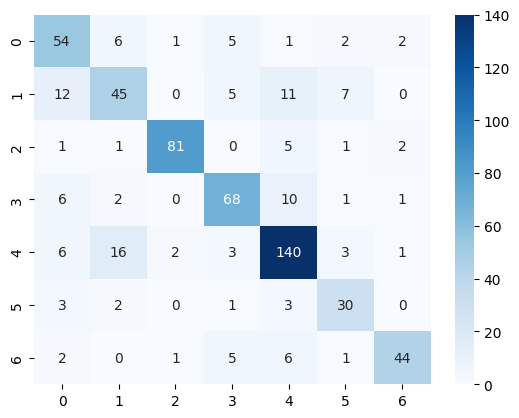

In [6]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score

model.eval()
y_pred = out.argmax(dim=1)[data.test_mask].detach().cpu()
y = data.y[data.test_mask].detach().cpu()

print(f"F1 score: {f1_score(y, y_pred, average='micro')}")
sns.heatmap(confusion_matrix(y, y_pred), annot=True, fmt='g', cmap='Blues')

# Graph Attention

Implementación disponible en [pytroch_geometric](https://pytorch-geometric.readthedocs.io/en/stable/generated/torch_geometric.nn.conv.GATConv.html#torch_geometric.nn.conv.GATConv)

$ \sum_{v \in \mathcal{N}(u)}{\frac{\exp(\text{MLP}_{\phi}( W^l x_u^{l-1} \oplus  W^l x_v^{l-1})}{\sum_{j' \in \mathcal{N}(i)} \exp(\text{MLP}_{\phi}( W^l x_u^{l-1} \oplus  W^l x_{v'}^{l-1}))}} $

* **MSG**: $ m_u^l = W^l x_u^{l-1} $
* **AGG**: $ a_u^l = \sum_{v \in \mathcal{N}(u)}{\frac{\exp(\text{MLP}_{\phi}(\mathbf{m}_u^{l-1} \oplus \mathbf{m}_v^{l-1}))}{\sum_{j' \in \mathcal{N}(i)} \exp(\text{MLP}_{\phi}(\mathbf{m}_u^{l-1} \oplus \mathbf{z}_{v'}^{l-1}))}} $
* **UPDATE**: $ z_u^l = a_u^l $


update no tiene nada, porque antes del sumatorio no hay na

## Implementación de la capa

In [ ]:
import torch
from torch_geometric.nn import MessagePassing, MLP
from torch_geometric.utils import add_self_loops, softmax

class CustomGATConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(CustomGATConv, self).__init__(aggr='sum')
        self.lin = torch.nn.Linear(in_channels, out_channels) # transformacion de paso de mensaje
        self.mlp_phi = MLP( # va a aprender el valor alpha
            in_channels=2*out_channels,
            out_channels=1, # salida 1, valor de agregacion
            hidden_channels=16,
            num_layers=1
        )

        self.reset_parameters()

    def reset_parameters(self):
        self.lin.reset_parameters()
        self.mlp_phi.reset_parameters()

    def forward(self, x, edge_index):
        # Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Linearly transform node feature matrix.
        z = self.lin(x)

        # Start propagating messages.
        return self.propagate(edge_index, size=(z.size(0), z.size(0)), x=z)

    def message(self, edge_index_i, x_i, x_j, size_i):
        # Compute attention coefficients. x_i es el nodo sobre el que se hace la agregacion, x_j es el vecino
        x_ij = torch.cat([x_i, x_j], dim=1)
        alpha = self.mlp_phi(x_ij)
        alpha = softmax(alpha, edge_index_i, num_nodes=size_i) # edge_index_i aristas del nodo sobre el que se quiere calcular softmax de sus vecinos

        return alpha * x_j

    def update(self, aggr_out):
        # aggr_out has shape [N, out_channels]

        # Return new node embeddings.
        return aggr_out

## Implementación de la red

In [14]:
import torch
import torch.nn.functional as F
# tambien disponible en GATConv
from torch_geometric.nn import GATConv, MLP

class GCN(torch.nn.Module):
    def __init__(self, node_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = CustomGATConv(node_features, hidden_channels)
        self.conv2 = CustomGATConv(hidden_channels, hidden_channels)
        self.cls = MLP(in_channels=hidden_channels, out_channels=num_classes, num_layers=2, hidden_channels=hidden_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.cls(x)
        return x

## Cargar dataset

In [15]:
from torch_geometric.datasets import CitationFull

dataset = CitationFull(root='CitationFull', name='Cora_ML')
print(f"Number of graphs: {len(dataset)}")

data = dataset[0]
print(f"Attributes: {data.keys()}")
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Number of node features: {data.num_node_features}")
print(f"Number of edge features: {data.num_edge_features}")
print(f"Number of classes: {dataset.num_classes}")
print(f"Contains isolated nodes: {data.has_isolated_nodes()}")
print(f"Contains self-loops: {data.has_self_loops()}")
print(f"Is undirected: {data.is_undirected()}")

Number of graphs: 1
Attributes: ['edge_index', 'y', 'x']
Number of nodes: 2995
Number of edges: 16316
Number of node features: 2879
Number of edge features: 0
Number of classes: 7
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


## Dividir dataset

In [16]:
import numpy as np
from sklearn.model_selection import train_test_split

train_idx, test_idx = train_test_split(np.arange(data.num_nodes), test_size=0.2, stratify=data.y)

train_mask = np.zeros(data.num_nodes, dtype=bool)
train_mask[train_idx] = True

test_mask = np.zeros(data.num_nodes, dtype=bool)
test_mask[test_idx] = True

data.train_mask = torch.tensor(train_mask)
data.test_mask = torch.tensor(test_mask)

## Train

In [17]:
from torch.nn import CrossEntropyLoss
from torchmetrics.classification import MulticlassF1Score
from torch.optim import Adam

model = GCN(dataset.num_node_features, 16, dataset.num_classes)

optimizer = Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
optm_func = CrossEntropyLoss()
metric = MulticlassF1Score(num_classes=dataset.num_classes)

model.train()
for epoch in range(1000):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = optm_func(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss {loss.item()}")

Epoch 0: Loss 1.9597359895706177
Epoch 10: Loss 1.3691911697387695
Epoch 20: Loss 1.0301332473754883
Epoch 30: Loss 0.8018800020217896
Epoch 40: Loss 0.6637001037597656
Epoch 50: Loss 0.560875654220581
Epoch 60: Loss 0.49386605620384216
Epoch 70: Loss 0.4691653251647949
Epoch 80: Loss 0.4525161683559418
Epoch 90: Loss 0.4240662753582001
Epoch 100: Loss 0.39378973841667175
Epoch 110: Loss 0.40034791827201843
Epoch 120: Loss 0.3734886050224304
Epoch 130: Loss 0.4029838740825653
Epoch 140: Loss 0.366110235452652
Epoch 150: Loss 0.39126232266426086
Epoch 160: Loss 0.36854875087738037
Epoch 170: Loss 0.35085102915763855
Epoch 180: Loss 0.3230777978897095
Epoch 190: Loss 0.33768337965011597
Epoch 200: Loss 0.3460543155670166
Epoch 210: Loss 0.33183524012565613
Epoch 220: Loss 0.2967245876789093
Epoch 230: Loss 0.3274936378002167
Epoch 240: Loss 0.2986040711402893
Epoch 250: Loss 0.3226926624774933
Epoch 260: Loss 0.3388288617134094
Epoch 270: Loss 0.32787880301475525
Epoch 280: Loss 0.327386

## Test model

F1 score: 0.8280467445742905


<Axes: >

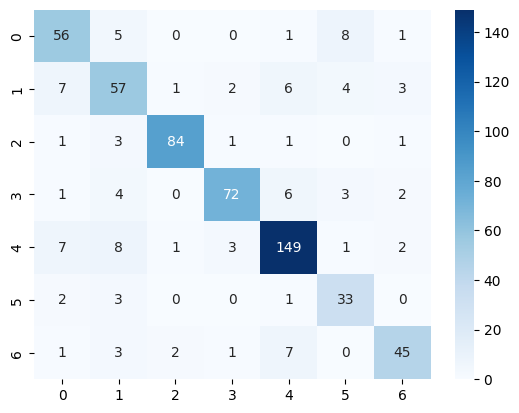

In [18]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score

model.eval()
y_pred = out.argmax(dim=1)[data.test_mask].detach().cpu()
y = data.y[data.test_mask].detach().cpu()

print(f"F1 score: {f1_score(y, y_pred, average='micro')}")
sns.heatmap(confusion_matrix(y, y_pred), annot=True, fmt='g', cmap='Blues')

# Concat skip connections

$ \mathbf{z}_i^{l} = W_{\theta}^l (z_i^{l-1} \oplus (W_{\phi}^l \sum_{j \in \mathcal{N}(i)} z_j^{l-1})) \ $

* **MSG**: $m_u^l = W_\phi^lz^{l-1}_u $
* **AGG**: $a_u^l = \sum_{v \in N(u)} m_v^l$ 
* **UPDATE**: $z_u^l = W_{\theta}^l (z_i^{l-1} \oplus a_u^l)$

In [50]:
import torch
from torch.nn import Linear, Parameter
from torch_geometric.nn import MessagePassing

class SkipConcatConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(SkipConcatConv, self).__init__(aggr='sum')
        
        self.W_theta = Linear(in_channels + out_channels, out_channels)
        self.b_theta = Parameter(torch.Tensor(out_channels))

        self.W_phi = Linear(in_channels, out_channels)
        self.b_phi = Parameter(torch.Tensor(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        self.W_theta.reset_parameters()
        self.b_theta.data.zero_()
        self.W_phi.reset_parameters()
        self.b_phi.data.zero_()

    def forward(self, x, edge_index):
        return self.propagate(edge_index, x=x, central_node=x)
    
    def message(self, x_j):
        return self.W_phi(x_j) + self.b_phi
    
    def update(self, aggr_out, central_node):
        a = torch.concat([central_node, aggr_out], dim=1)
        return self.W_theta(a) + self.b_theta

## Implementación de la red

In [51]:
import torch
import torch.nn.functional as F
# tambien disponible en GATConv
from torch_geometric.nn import MLP

class GCN(torch.nn.Module):
    def __init__(self, node_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = SkipConcatConv(node_features, hidden_channels)
        self.conv2 = SkipConcatConv(hidden_channels, hidden_channels)
        self.cls = MLP(in_channels=hidden_channels, out_channels=num_classes, num_layers=2, hidden_channels=hidden_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.cls(x)
        return x

## Cargar dataset

In [37]:
from torch_geometric.datasets import CitationFull

dataset = CitationFull(root='CitationFull', name='Cora_ML')
print(f"Number of graphs: {len(dataset)}")

data = dataset[0]
print(f"Attributes: {data.keys()}")
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Number of node features: {data.num_node_features}")
print(f"Number of edge features: {data.num_edge_features}")
print(f"Number of classes: {dataset.num_classes}")
print(f"Contains isolated nodes: {data.has_isolated_nodes()}")
print(f"Contains self-loops: {data.has_self_loops()}")
print(f"Is undirected: {data.is_undirected()}")

Number of graphs: 1
Attributes: ['edge_index', 'y', 'x']
Number of nodes: 2995
Number of edges: 16316
Number of node features: 2879
Number of edge features: 0
Number of classes: 7
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


## Dividir dataset

In [38]:
import numpy as np
from sklearn.model_selection import train_test_split

train_idx, test_idx = train_test_split(np.arange(data.num_nodes), test_size=0.2, stratify=data.y)

train_mask = np.zeros(data.num_nodes, dtype=bool)
train_mask[train_idx] = True

test_mask = np.zeros(data.num_nodes, dtype=bool)
test_mask[test_idx] = True

data.train_mask = torch.tensor(train_mask)
data.test_mask = torch.tensor(test_mask)

## Train

In [52]:
from torch.nn import CrossEntropyLoss
from torchmetrics.classification import MulticlassF1Score
from torch.optim import Adam

model = GCN(dataset.num_node_features, 16, dataset.num_classes)

optimizer = Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
optm_func = CrossEntropyLoss()
metric = MulticlassF1Score(num_classes=dataset.num_classes)

model.train()
for epoch in range(500):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = optm_func(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss {loss.item()}")

Epoch 0: Loss 2.0202910900115967
Epoch 10: Loss 1.7034051418304443
Epoch 20: Loss 1.5372921228408813
Epoch 30: Loss 1.375361680984497
Epoch 40: Loss 1.2028220891952515
Epoch 50: Loss 0.9817267656326294
Epoch 60: Loss 0.8376266360282898
Epoch 70: Loss 0.6989253163337708
Epoch 80: Loss 0.6191953420639038
Epoch 90: Loss 0.5685120224952698
Epoch 100: Loss 0.47474077343940735
Epoch 110: Loss 0.45223188400268555
Epoch 120: Loss 0.4300173223018646
Epoch 130: Loss 0.40478822588920593
Epoch 140: Loss 0.3867104649543762
Epoch 150: Loss 0.4108926057815552
Epoch 160: Loss 0.3813628554344177
Epoch 170: Loss 0.3723587095737457
Epoch 180: Loss 0.35405316948890686
Epoch 190: Loss 0.3226175308227539
Epoch 200: Loss 0.31528592109680176
Epoch 210: Loss 0.348154217004776
Epoch 220: Loss 0.348397821187973
Epoch 230: Loss 0.3274975121021271
Epoch 240: Loss 0.35632267594337463
Epoch 250: Loss 0.32201990485191345
Epoch 260: Loss 0.3093873858451843
Epoch 270: Loss 0.329556405544281
Epoch 280: Loss 0.3150547146

## Test model

F1 score: 0.7829716193656093


<Axes: >

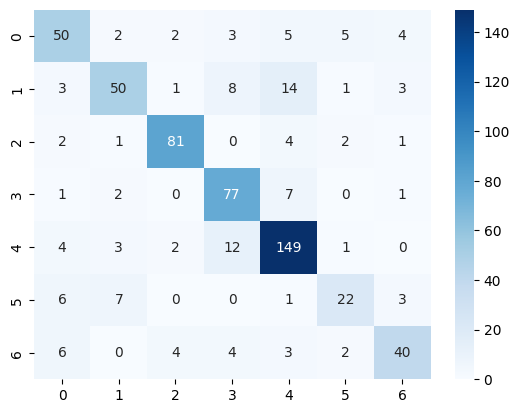

In [54]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score

model.eval()
y_pred = out.argmax(dim=1)[data.test_mask].detach().cpu()
y = data.y[data.test_mask].detach().cpu()

print(f"F1 score: {f1_score(y, y_pred, average='micro')}")
sns.heatmap(confusion_matrix(y, y_pred), annot=True, fmt='g', cmap='Blues')

# Interpolate skip connection

$ \mathbf{z}_i^{l} =\alpha^l \odot (W_{\theta}^l z_i^{l-1}) + (1-\alpha^l ) \odot (W_{\phi}^l \sum_{j \in \mathcal{N}(i)} z_j^{l-1}) \ $

* **MSG**: $m_u^l = W_\phi^lz^{l-1}_u $
* **AGG**: $a_u^l = \sum_{v \in N(u)} m_v^l$ 
* **UPDATE**: $z_u^l = \alpha^l \odot (W_\theta z_i^{l-1}) + (1-\alpha^l) \odot a_u^l $

In [ ]:
import torch
from torch.nn import Linear, Parameter
from torch_geometric.nn import MessagePassing

class InterpolateSkipConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(InterpolateSkipConv, self).__init__(aggr='sum')
        
        self.W_theta = Linear(in_channels, out_channels)
        self.b_theta = Parameter(torch.Tensor(out_channels))

        self.W_phi = Linear(in_channels, out_channels)
        self.b_phi = Parameter(torch.Tensor(out_channels))

        self.alpha = Parameter(torch.Tensor(1))

        self.reset_parameters()

    def reset_parameters(self):
        self.W_theta.reset_parameters()
        self.b_theta.data.zero_()
        self.W_phi.reset_parameters()
        self.b_phi.data.zero_()
        self.alpha.data.fill_(0.5)

    def forward(self, x, edge_index):
        return self.propagate(edge_index, x=x, central_node=x)
    
    def message(self, x_j):
        return self.W_phi(x_j) + self.b_phi
    
    def update(self, aggr_out, central_node):
        z_i = self.W_theta(central_node) + self.b_theta
        return self.alpha * z_i + (1 - self.alpha) * aggr_out

## Implementación de la red

In [ ]:
import torch
import torch.nn.functional as F
# tambien disponible en GATConv
from torch_geometric.nn import MLP

class GCN(torch.nn.Module):
    def __init__(self, node_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = InterpolateSkipConv(node_features, hidden_channels)
        self.conv2 = InterpolateSkipConv(hidden_channels, hidden_channels)
        self.cls = MLP(in_channels=hidden_channels, out_channels=num_classes, num_layers=2, hidden_channels=hidden_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.cls(x)
        return x

## Cargar dataset

In [57]:
from torch_geometric.datasets import CitationFull

dataset = CitationFull(root='CitationFull', name='Cora_ML')
print(f"Number of graphs: {len(dataset)}")

data = dataset[0]
print(f"Attributes: {data.keys()}")
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Number of node features: {data.num_node_features}")
print(f"Number of edge features: {data.num_edge_features}")
print(f"Number of classes: {dataset.num_classes}")
print(f"Contains isolated nodes: {data.has_isolated_nodes()}")
print(f"Contains self-loops: {data.has_self_loops()}")
print(f"Is undirected: {data.is_undirected()}")

Number of graphs: 1
Attributes: ['edge_index', 'y', 'x']
Number of nodes: 2995
Number of edges: 16316
Number of node features: 2879
Number of edge features: 0
Number of classes: 7
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


## Dividir dataset

In [58]:
import numpy as np
from sklearn.model_selection import train_test_split

train_idx, test_idx = train_test_split(np.arange(data.num_nodes), test_size=0.2, stratify=data.y)

train_mask = np.zeros(data.num_nodes, dtype=bool)
train_mask[train_idx] = True

test_mask = np.zeros(data.num_nodes, dtype=bool)
test_mask[test_idx] = True

data.train_mask = torch.tensor(train_mask)
data.test_mask = torch.tensor(test_mask)

## Train

In [59]:
from torch.nn import CrossEntropyLoss
from torchmetrics.classification import MulticlassF1Score
from torch.optim import Adam

model = GCN(dataset.num_node_features, 16, dataset.num_classes)

optimizer = Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
optm_func = CrossEntropyLoss()
metric = MulticlassF1Score(num_classes=dataset.num_classes)

model.train()
for epoch in range(500):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = optm_func(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss {loss.item()}")

Epoch 0: Loss 2.00000262260437
Epoch 10: Loss 1.6787484884262085
Epoch 20: Loss 1.499092698097229
Epoch 30: Loss 1.3002243041992188
Epoch 40: Loss 1.0039710998535156
Epoch 50: Loss 0.759504497051239
Epoch 60: Loss 0.6132368445396423
Epoch 70: Loss 0.5545724630355835
Epoch 80: Loss 0.47124183177948
Epoch 90: Loss 0.487814724445343
Epoch 100: Loss 0.4820616841316223
Epoch 110: Loss 0.42864158749580383
Epoch 120: Loss 0.40538954734802246
Epoch 130: Loss 0.416923850774765
Epoch 140: Loss 0.40199214220046997
Epoch 150: Loss 0.3850290775299072
Epoch 160: Loss 0.39958280324935913
Epoch 170: Loss 0.39323484897613525
Epoch 180: Loss 0.40327998995780945
Epoch 190: Loss 0.4140852987766266
Epoch 200: Loss 0.362079918384552
Epoch 210: Loss 0.3671644330024719
Epoch 220: Loss 0.3612695634365082
Epoch 230: Loss 0.35397103428840637
Epoch 240: Loss 0.3494463860988617
Epoch 250: Loss 0.34873005747795105
Epoch 260: Loss 0.3211630880832672
Epoch 270: Loss 0.34641027450561523
Epoch 280: Loss 0.3581615686416

## Test model

F1 score: 0.7562604340567612


<Axes: >

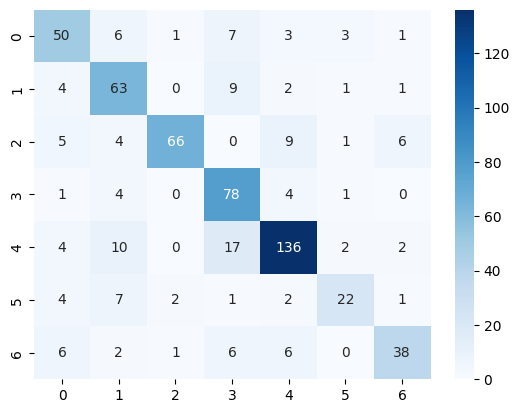

In [60]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score

model.eval()
y_pred = out.argmax(dim=1)[data.test_mask].detach().cpu()
y = data.y[data.test_mask].detach().cpu()

print(f"F1 score: {f1_score(y, y_pred, average='micro')}")
sns.heatmap(confusion_matrix(y, y_pred), annot=True, fmt='g', cmap='Blues')

# GRU skip connections

Implementación disponible en [pytorch_geometric](https://pytorch-geometric.readthedocs.io/en/stable/generated/torch_geometric.nn.conv.GatedGraphConv.html#torch_geometric.nn.conv.GatedGraphConv)

## GRU update

* Entradas:
    * $ x^t = z_u^{l-1} $
    * $ h^{t-1} = a_u^l $

* Salida: $h^t$

* Ecuaciones:

$ r_t = \sigma(W_{ir} x_t + W_{hr} h_{(t-1)} ) $

$ z_t = \sigma(W_{iz} x_t + W_{hz} h_{(t-1)}) $

$ n_t = \tanh(W_{in} x_t + r_t \odot W_{hn} h_{(t-1)}) $

$ h_t = (1 - z_t) \odot n_t + z_t \odot h_{(t-1)} $



In [1]:
import torch
import torch.nn as nn

class UpdateGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        """
        Custom GRU based on the given equations.
        
        Args:
            input_dim (int): Dimension of the input vector x.
            hidden_dim (int): Dimension of the hidden state h.
        """
        super(UpdateGRU, self).__init__()
        self.hidden_dim = hidden_dim
        
        # Input-to-hidden weights and biases
        self.W_ir = nn.Linear(input_dim, hidden_dim, bias=True)
        self.W_iz = nn.Linear(input_dim, hidden_dim, bias=True)
        self.W_in = nn.Linear(input_dim, hidden_dim, bias=True)
        
        # Hidden-to-hidden weights and biases
        self.W_hr = nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.W_hz = nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.W_hn = nn.Linear(hidden_dim, hidden_dim, bias=True)
        
        # Activation functions
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()

    def reset_parameters(self):
        self.W_ir.reset_parameters()
        self.W_iz.reset_parameters()
        self.W_in.reset_parameters()
        self.W_hr.reset_parameters()
        self.W_hz.reset_parameters()
        self.W_hn.reset_parameters

    def forward(self, x_t, h_t_minus_1):
        """
        Forward pass for a single time step.
        
        Args:
            x_t (torch.Tensor): Input vector at time t, shape (batch_size, input_dim).
            h_t_minus_1 (torch.Tensor): Hidden state at time t-1, shape (batch_size, hidden_dim).
        
        Returns:
            h_t (torch.Tensor): Updated hidden state at time t, shape (batch_size, hidden_dim).
        """
        # Compute reset gate
        r_t = self.sigmoid(self.W_ir(x_t) + self.W_hr(h_t_minus_1))
        
        # Compute update gate
        z_t = self.sigmoid(self.W_iz(x_t) + self.W_hz(h_t_minus_1))
        
        # Compute candidate hidden state
        n_t = self.tanh(self.W_in(x_t) + r_t * self.W_hn(h_t_minus_1))
        
        # Compute new hidden state
        h_t = (1 - z_t) * n_t + z_t * h_t_minus_1
        
        return h_t

## GRU skip connection layer

$ z_i^l = \text{GRU}(W_{\phi}^l \sum_{j \in \mathcal{N}(i)} z_j^{l-1}, z_i^{t-1}) $

* **MSG**: $m_u^l = W_\phi^lz^{l-1}_u $
* **AGG**: $a_u^l = \sum_{v \in N(u)} m_v^l$ 
* **UPDATE**: $z_u^l = \text{GRU}(a_u^l, z_u^{l-1}) $

In [2]:
import torch
from torch.nn import Linear
from torch_geometric.nn import MessagePassing

class GRUConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(GRUConv, self).__init__(aggr='sum')

        self.W_phi = Linear(in_channels, out_channels, bias=True)
        self.gru = UpdateGRU(in_channels, out_channels)

        self.reset_parameters()

    def reset_parameters(self):
        self.W_phi.reset_parameters()
        self.gru.reset_parameters()

    def forward(self, x, edge_index):
        return self.propagate(edge_index, x=x, central_node=x)
    
    def message(self, x_j):
        return self.W_phi(x_j)
    
    def update(self, aggr_out, central_node):
        return self.gru(central_node, aggr_out)

## Implementación de la red

In [3]:
import torch
import torch.nn.functional as F
# tambien disponible en GATConv
from torch_geometric.nn import MLP

class GCN(torch.nn.Module):
    def __init__(self, node_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GRUConv(node_features, hidden_channels)
        self.conv2 = GRUConv(hidden_channels, hidden_channels)
        self.cls = MLP(in_channels=hidden_channels, out_channels=num_classes, num_layers=2, hidden_channels=hidden_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.cls(x)
        return x

## Cargar dataset

In [4]:
from torch_geometric.datasets import CitationFull

dataset = CitationFull(root='CitationFull', name='Cora_ML')
print(f"Number of graphs: {len(dataset)}")

data = dataset[0]
print(f"Attributes: {data.keys()}")
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Number of node features: {data.num_node_features}")
print(f"Number of edge features: {data.num_edge_features}")
print(f"Number of classes: {dataset.num_classes}")
print(f"Contains isolated nodes: {data.has_isolated_nodes()}")
print(f"Contains self-loops: {data.has_self_loops()}")
print(f"Is undirected: {data.is_undirected()}")

Number of graphs: 1
Attributes: ['x', 'edge_index', 'y']
Number of nodes: 2995
Number of edges: 16316
Number of node features: 2879
Number of edge features: 0
Number of classes: 7
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


## Dividir dataset

In [5]:
import numpy as np
from sklearn.model_selection import train_test_split

train_idx, test_idx = train_test_split(np.arange(data.num_nodes), test_size=0.2, stratify=data.y)

train_mask = np.zeros(data.num_nodes, dtype=bool)
train_mask[train_idx] = True

test_mask = np.zeros(data.num_nodes, dtype=bool)
test_mask[test_idx] = True

data.train_mask = torch.tensor(train_mask)
data.test_mask = torch.tensor(test_mask)

## Train

In [6]:
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

model = GCN(dataset.num_node_features, 16, dataset.num_classes)

optimizer = Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
optm_func = CrossEntropyLoss()

model.train()
for epoch in range(500):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = optm_func(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss {loss.item()}")

Epoch 0: Loss 1.9259428977966309
Epoch 10: Loss 1.7988197803497314
Epoch 20: Loss 1.7048900127410889
Epoch 30: Loss 1.6418403387069702
Epoch 40: Loss 1.5478209257125854
Epoch 50: Loss 1.5188835859298706
Epoch 60: Loss 1.4630635976791382
Epoch 70: Loss 1.3646223545074463
Epoch 80: Loss 1.2592042684555054
Epoch 90: Loss 1.0767492055892944
Epoch 100: Loss 0.9691735506057739
Epoch 110: Loss 0.9828261137008667
Epoch 120: Loss 0.9056493043899536
Epoch 130: Loss 0.8036960363388062
Epoch 140: Loss 0.7350432872772217
Epoch 150: Loss 0.7201147079467773
Epoch 160: Loss 0.6499743461608887
Epoch 170: Loss 0.6138747334480286
Epoch 180: Loss 0.5495741963386536
Epoch 190: Loss 0.5157570838928223
Epoch 200: Loss 0.49001437425613403
Epoch 210: Loss 0.4659014344215393
Epoch 220: Loss 0.43345171213150024
Epoch 230: Loss 0.44242316484451294
Epoch 240: Loss 0.4191240966320038
Epoch 250: Loss 0.3698844909667969
Epoch 260: Loss 0.38642561435699463
Epoch 270: Loss 0.36545154452323914
Epoch 280: Loss 0.35492748

## Test model

F1 score: 0.8030050083472454


<Axes: >

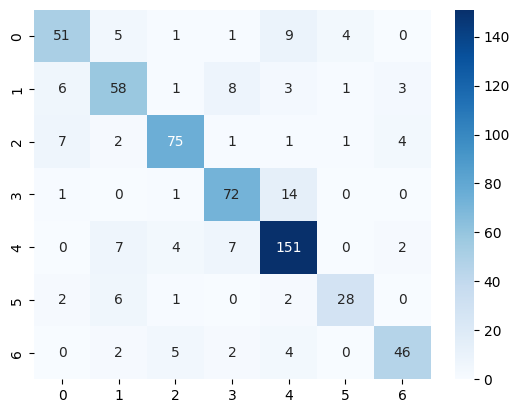

In [7]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score

model.eval()
y_pred = out.argmax(dim=1)[data.test_mask].detach().cpu()
y = data.y[data.test_mask].detach().cpu()

print(f"F1 score: {f1_score(y, y_pred, average='micro')}")
sns.heatmap(confusion_matrix(y, y_pred), annot=True, fmt='g', cmap='Blues')

# Jumping knowledge

Disponible en [pytorch_geometric](https://pytorch-geometric.readthedocs.io/en/stable/generated/torch_geometric.nn.models.JumpingKnowledge.html)



In [ ]:
import torch
from torch_geometric.nn import GCNConv, MLP, JumpingKnowledge
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self, node_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.jk = JumpingKnowledge(mode='cat')
        self.cls = MLP(in_channels=hidden_channels*2, out_channels=num_classes, num_layers=1) # 2 es el numero de capas, para generalizar , n capas

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x_1 = F.relu(x)
        x = self.conv2(x, edge_index)
        x_2 = F.relu(x)
        x = self.jk([x_1, x_2])
        x = self.cls(x)
        return x

C:\Users\Angel Panizo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch_geometric\typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: [WinError 127] No se encontró el proceso especificado
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
C:\Users\Angel Panizo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch_geometric\typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: [WinError 127] No se encontró el proceso especificado
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
C:\Users\Angel Panizo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch_geometric\typing.py:113: UserWarning: An issue occur

## Cargar dataset

In [2]:
from torch_geometric.datasets import CitationFull

dataset = CitationFull(root='CitationFull', name='Cora_ML')
print(f"Number of graphs: {len(dataset)}")

data = dataset[0]
print(f"Attributes: {data.keys()}")
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Number of node features: {data.num_node_features}")
print(f"Number of edge features: {data.num_edge_features}")
print(f"Number of classes: {dataset.num_classes}")
print(f"Contains isolated nodes: {data.has_isolated_nodes()}")
print(f"Contains self-loops: {data.has_self_loops()}")
print(f"Is undirected: {data.is_undirected()}")

Number of graphs: 1
Attributes: ['y', 'edge_index', 'x']
Number of nodes: 2995
Number of edges: 16316
Number of node features: 2879
Number of edge features: 0
Number of classes: 7
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


## Dividir dataset

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split

train_idx, test_idx = train_test_split(np.arange(data.num_nodes), test_size=0.2, stratify=data.y)

train_mask = np.zeros(data.num_nodes, dtype=bool)
train_mask[train_idx] = True

test_mask = np.zeros(data.num_nodes, dtype=bool)
test_mask[test_idx] = True

data.train_mask = torch.tensor(train_mask)
data.test_mask = torch.tensor(test_mask)

## Train

In [4]:
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

model = GCN(dataset.num_node_features, 16, dataset.num_classes)

optimizer = Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
optm_func = CrossEntropyLoss()

model.train()
for epoch in range(500):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = optm_func(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss {loss.item()}")

Epoch 0: Loss 1.946506142616272
Epoch 10: Loss 0.6916095018386841
Epoch 20: Loss 0.22733713686466217
Epoch 30: Loss 0.12355022132396698
Epoch 40: Loss 0.07788509130477905
Epoch 50: Loss 0.0606655590236187
Epoch 60: Loss 0.052503932267427444
Epoch 70: Loss 0.04603101313114166
Epoch 80: Loss 0.04296857491135597
Epoch 90: Loss 0.03912689536809921
Epoch 100: Loss 0.03305814415216446
Epoch 110: Loss 0.030634598806500435
Epoch 120: Loss 0.028691373765468597
Epoch 130: Loss 0.02711031213402748
Epoch 140: Loss 0.03307686373591423
Epoch 150: Loss 0.024179399013519287
Epoch 160: Loss 0.02317662350833416
Epoch 170: Loss 0.02255486510694027
Epoch 180: Loss 0.021733896806836128
Epoch 190: Loss 0.021654780954122543
Epoch 200: Loss 0.020666340366005898
Epoch 210: Loss 0.019614452496170998
Epoch 220: Loss 0.018810318782925606
Epoch 230: Loss 0.018314190208911896
Epoch 240: Loss 0.01861388050019741
Epoch 250: Loss 0.01805298961699009
Epoch 260: Loss 0.020135799422860146
Epoch 270: Loss 0.01857263781130

## Test model

F1 score: 0.8631051752921536


<Axes: >

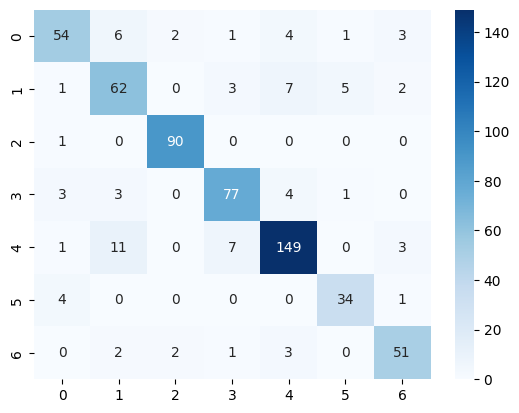

In [5]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score

model.eval()
y_pred = out.argmax(dim=1)[data.test_mask].detach().cpu()
y = data.y[data.test_mask].detach().cpu()

print(f"F1 score: {f1_score(y, y_pred, average='micro')}")
sns.heatmap(confusion_matrix(y, y_pred), annot=True, fmt='g', cmap='Blues')